In [1]:
import kagglehub

# Download latest version
pth = kagglehub.dataset_download("preetviradiya/brian-tumor-dataset")

print("Path to dataset files:", pth)

Path to dataset files: /kaggle/input/brian-tumor-dataset


# **Importing Libraries**

In [2]:
import os as osx
import json
import torch as trc
import torch.nn as nnx
import torch.optim as optimx
import numpy as npx
import matplotlib.pyplot as pltx
import seaborn as snsx
from torchvision import datasets as dtsts, models as mdls, transforms as trnsfrms
from torch.utils.data import random_split as randomx_splt, DataLoader as dtldr
from tqdm import tqdm
import random as randomx
from torch.optim.lr_scheduler import ReduceLROnPlateau as rlrp
from sklearn.metrics import (confusion_matrix as cfm_mtx, classification_report as cls_rpt,
                             accuracy_score as acc_scr, precision_score as precx,
                             recall_score as rec_scr, f1_score as f1x, roc_curve,
                             roc_auc_score as auc_scr)
from sklearn.model_selection import train_test_split as ttsx
from PIL import Image as Img
from torchvision.models import ResNet50_Weights as ResNet50_Wghts
from torchvision.transforms.functional import to_pil_image

Check Availability of Cuda

In [3]:
dvc = trc.device("cuda" if trc.cuda.is_available() else "cpu")
print("Using device:", dvc)

Using device: cuda


In [4]:
class config:
    resnet50mdl_path = None
    resnet50mdl_hstry=None
    enable_training=True
    def check_training_status():
        return config.enable_training


# **Spliting Data in Brain Tumor and Healthy**

In [5]:
yes_dr = osx.path.join(pth, 'Brain Tumor Data Set', 'Brain Tumor Data Set','Brain Tumor')
no_dr = osx.path.join(pth, 'Brain Tumor Data Set', 'Brain Tumor Data Set','Healthy')

# List all files
yes_fles = [osx.path.join(yes_dr, f) for f in osx.listdir(yes_dr) if osx.path.isfile(osx.path.join(yes_dr, f))]
no_fles = [osx.path.join(no_dr, f) for f in osx.listdir(no_dr) if osx.path.isfile(osx.path.join(no_dr, f))]

# Select a subset of files
num_fles_to_slct = 1500

slctd_yes_fles = randomx.sample(yes_fles, min(num_fles_to_slct, len(yes_fles)))
slctd_no_fles = randomx.sample(no_fles, min(num_fles_to_slct, len(no_fles)))
slctd_fles=slctd_yes_fles+slctd_no_fles
print(f"Selected {len(slctd_yes_fles)} 'yes' files")
print(f"Selected {len(slctd_no_fles)} 'no' files")


Selected 1500 'yes' files
Selected 1500 'no' files


# **Visualization**

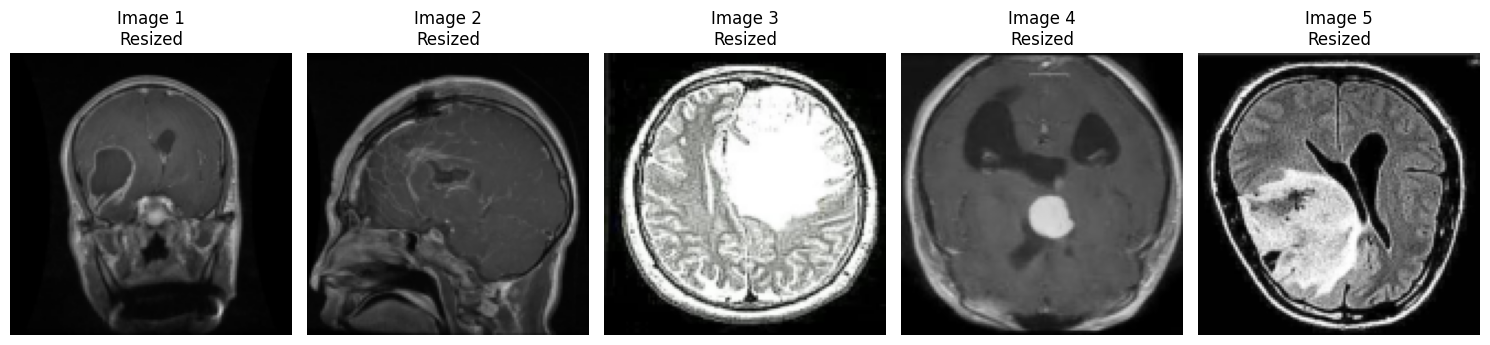

In [6]:
# Define the transformation
trnsfrm = trnsfrms.Compose([
    trnsfrms.Resize((128, 128)), # Resize to a smaller size for visualization
    trnsfrms.ToTensor() # Convert to PyTorch tensor
])

# Select a few images to visualize
nm_img_to_vislize = 5
smple_img_pths = slctd_fles[:nm_img_to_vislize]

pltx.figure(figsize=(15, 5))
for i, img_path in enumerate(smple_img_pths):
    img = Img.open(img_path).convert('RGB') # Ensure image is in RGB format
    trnsfrmd_img = trnsfrm(img)

    pltx.subplot(1, nm_img_to_vislize, i + 1)
    pltx.imshow(trnsfrmd_img.permute(1, 2, 0)) # Permute back to HxWx channels for plotting
    pltx.title(f"Image {i+1}\nResized")
    pltx.axis('off')

pltx.tight_layout()
pltx.show()

# **Train, Validate and Test Dataframe splits**

In [7]:
# Split the data into train, validation, and test sets
trn_df, tst_df = ttsx(slctd_fles, train_size = 0.95, random_state = 0)
trn_df,val_df = ttsx(trn_df, train_size=0.9,random_state = 0)


print(f"\nNumber of samples in training set: {len(trn_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(tst_df)}")


Number of samples in training set: 2565
Number of samples in validation set: 285
Number of samples in test set: 150


Distribution of classes in Train, Validate and Test Sets

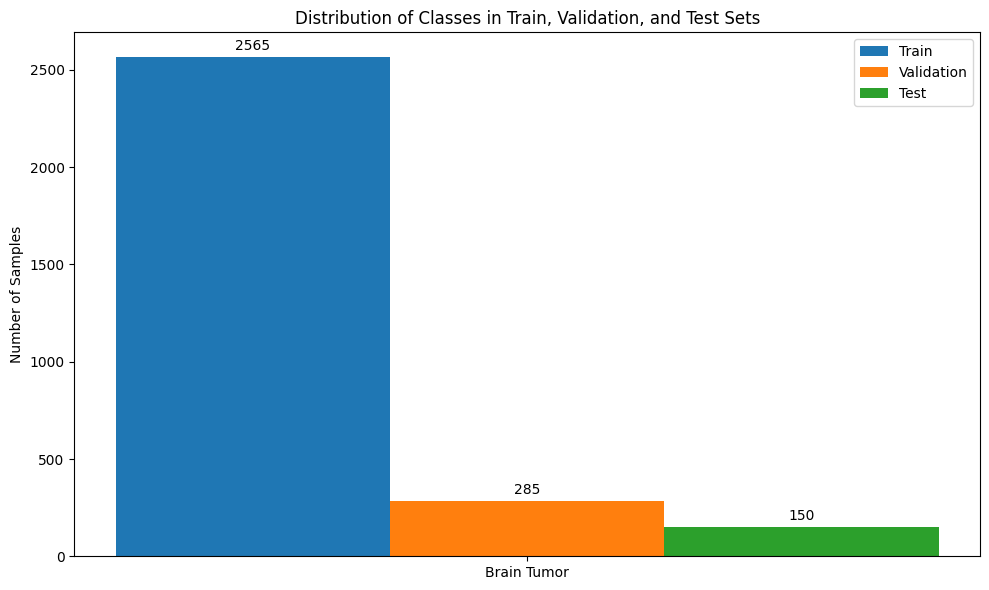

In [8]:
# Function to get class label from file path
def get_clss_lbl(fle_pth):
  if 'Brain Tumor' in fle_pth:
    return 'Brain Tumor'
  elif 'Healthy' in fle_pth:
    return 'Healthy'
  else:
    return 'Unknown'

# Getting labels for each set
trn_lbls = [get_clss_lbl(f) for f in trn_df]
val_lbls = [get_clss_lbl(f) for f in val_df]
tst_lbls = [get_clss_lbl(f) for f in tst_df]

# Counting the occurrences of each class in each set
trn_cnts = {}
for lbl in trn_lbls:
  trn_cnts[lbl] = trn_cnts.get(lbl, 0) + 1

val_cnts = {}
for lbl in val_lbls:
  val_cnts[lbl] = val_cnts.get(lbl, 0) + 1

tst_cnts = {}
for lbl in tst_lbls:
  tst_cnts[lbl] = tst_cnts.get(lbl, 0) + 1

# Preparing data for plotting
lbls = list(set(trn_lbls + val_lbls + tst_lbls))
trn_vlus = [trn_cnts.get(lbl, 0) for lbl in lbls]
val_vlus = [val_cnts.get(lbl, 0) for lbl in lbls]
tst_vlus = [tst_cnts.get(lbl, 0) for lbl in lbls]

x = range(len(lbls))
wdth = 0.25

fig, ax = pltx.subplots(figsize=(10, 6))
rects1 = ax.bar([i - wdth for i in x], trn_vlus, wdth, label='Train')
rects2 = ax.bar(x, val_vlus, wdth, label='Validation')
rects3 = ax.bar([i + wdth for i in x], tst_vlus, wdth, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of Classes in Train, Validation, and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(lbls)
ax.legend()

def autolbl(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        hght = rect.get_height()
        ax.annotate('{}'.format(hght),
                    xy=(rect.get_x() + rect.get_width() / 2, hght),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolbl(rects1)
autolbl(rects2)
autolbl(rects3)


fig.tight_layout()
pltx.show()

In [9]:
# Function to count 'yes' and 'no' files in a list of file paths
def cnt_yes_no(fle_lst, yes_dr, no_dr):
  yes_cnt = 0
  no_cnt = 0
  for fle_pth in fle_lst:
    if fle_pth.startswith(yes_dr):
      yes_cnt += 1
    elif fle_pth.startswith(no_dr):
      no_cnt += 1
  return yes_cnt, no_cnt

# Counting for training set
trn_yes_cnt, trn_no_cnt = cnt_yes_no(trn_df, yes_dr, no_dr)
print(f"\nTraining Set: Yes = {trn_yes_cnt}, No = {trn_no_cnt}")

# Count for validation set
val_yes_cnt, val_no_cnt = cnt_yes_no(val_df, yes_dr, no_dr)
print(f"Validation Set: Yes = {val_yes_cnt}, No = {val_no_cnt}")

# Count for test set
tst_yes_cnt, tst_no_cnt = cnt_yes_no(tst_df, yes_dr, no_dr)
print(f"Test Set: Yes = {tst_yes_cnt}, No = {tst_no_cnt}")



Training Set: Yes = 1289, No = 1276
Validation Set: Yes = 130, No = 155
Test Set: Yes = 81, No = 69


Distribution graph for yes and no in Train,Validate and Test Sets

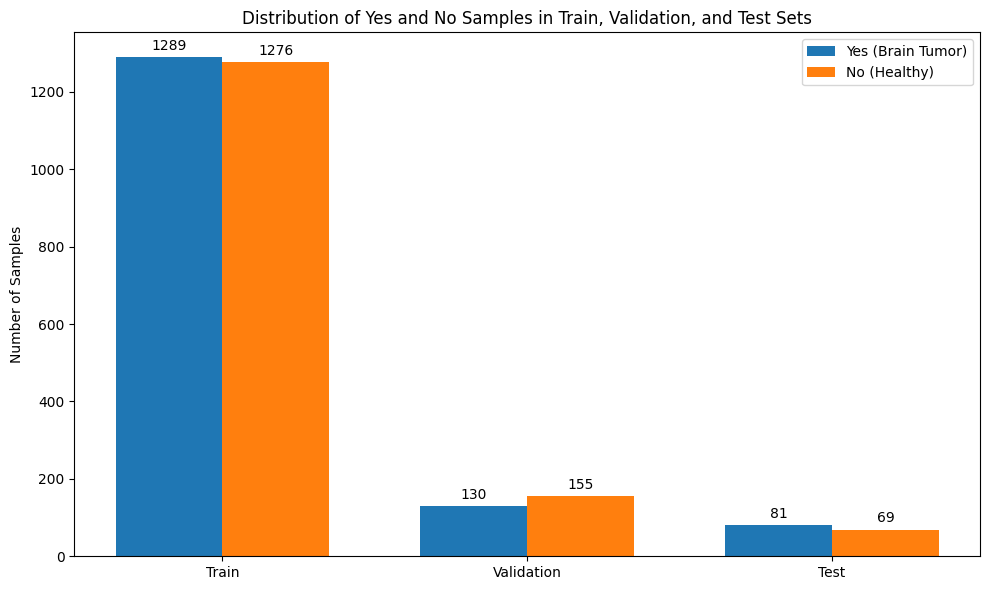

In [10]:
# Preparing data for plotting the distribution of 'Yes' and 'No' samples
sts = ['Train', 'Validation', 'Test']
yes_cnts = [trn_yes_cnt, val_yes_cnt, tst_yes_cnt]
no_cnts = [trn_no_cnt, val_no_cnt, tst_no_cnt]

x = range(len(sts))
wdth = 0.35

fig, ax = pltx.subplots(figsize=(10, 6))
rects1 = ax.bar([i - wdth/2 for i in x], yes_cnts, wdth, label='Yes (Brain Tumor)')
rects2 = ax.bar([i + wdth/2 for i in x], no_cnts, wdth, label='No (Healthy)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of Yes and No Samples in Train, Validation, and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(sts)
ax.legend()

autolbl(rects1)
autolbl(rects2)

fig.tight_layout()
pltx.show()

In [11]:
# Define batch size
btch_sze = 32

# **Transforming the data**

In [12]:
# Function to assign labels (0 for 'no', 1 for 'yes')
def get_lbl(fle_pth, yes_dr):
    if fle_pth.startswith(yes_dr):
        return 1  # 'yes' (Brain Tumor)
    else:
        return 0  # 'no' (Healthy)

# Apply labels to the file lists
trn_dta = [(f, get_lbl(f, yes_dr)) for f in trn_df]
val_dta = [(f, get_lbl(f, yes_dr)) for f in val_df]
tst_dta = [(f, get_lbl(f, yes_dr)) for f in tst_df]

# Define transformations for training and validation/testing
# Data augmentation for training data
trn_trnsfrms = trnsfrms.Compose([
    trnsfrms.Resize((224, 224)),  # Resize images to 224x224
    trnsfrms.RandomRotation(15),  # Randomly rotate by up to 15 degrees
    trnsfrms.RandomHorizontalFlip(),  # Randomly flip horizontally
    trnsfrms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random color changes
    trnsfrms.ToTensor(),  # Convert to PyTorch tensor
    trnsfrms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])

# No data augmentation for validation and test data
val_tst_trnsfrms = trnsfrms.Compose([
    trnsfrms.Resize((224, 224)),  # Resize images to 224x224
    trnsfrms.ToTensor(),  # Convert to PyTorch tensor
    trnsfrms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize with ImageNet stats
])


# Custom Dataset class
class TumorDtst(trc.utils.data.Dataset):
    def __init__(self, data, trnsfrms=None):
        self.data = data
        self.trnsfrms = trnsfrms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_pth, lbl = self.data[idx]
        img = Img.open(img_pth).convert('RGB') # Ensure image is in RGB
        if self.trnsfrms:
            img = self.trnsfrms(img)
        return img, lbl

# Create Dataset instances
trn_dtst = TumorDtst(trn_dta, trnsfrms=trn_trnsfrms)
val_dtst = TumorDtst(val_dta, trnsfrms=val_tst_trnsfrms)
tst_dtst = TumorDtst(tst_dta, trnsfrms=val_tst_trnsfrms)

# Create DataLoaders
trn_ldr = dtldr(trn_dtst, batch_size=btch_sze, shuffle=True, num_workers=2)
val_ldr = dtldr(val_dtst, batch_size=btch_sze, shuffle=False, num_workers=2)
tst_ldr = dtldr(tst_dtst, batch_size=btch_sze, shuffle=False, num_workers=2)

print(f"\nNumber of batches in training loader: {len(trn_ldr)}")
print(f"Number of batches in validation loader: {len(val_ldr)}")
print(f"Number of batches in test loader: {len(tst_ldr)}")



Number of batches in training loader: 81
Number of batches in validation loader: 9
Number of batches in test loader: 5


Distribution of Yes/No Samples

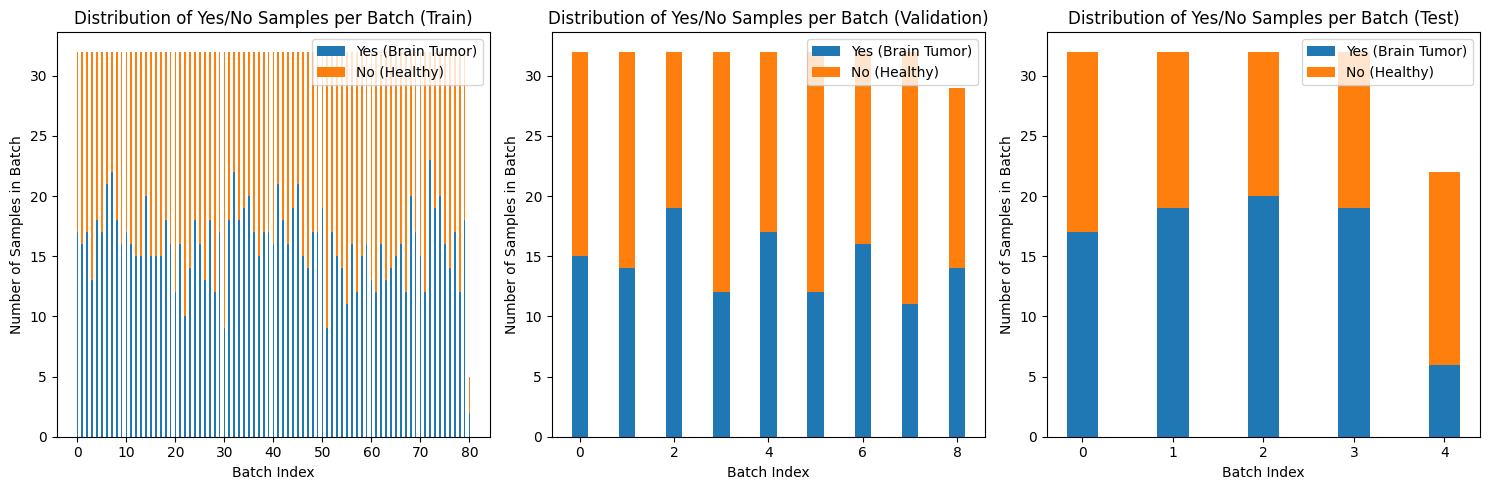

In [13]:
# Function to count 'yes' and 'no' files in a batch of file paths (assuming the original list of files is used to create batches)

def cnt_yes_no_btch(btch_lbls):
    yes_cnt = trc.sum(btch_lbls == 1).item()
    no_cnt = trc.sum(btch_lbls == 0).item()
    return yes_cnt, no_cnt

# Collect batch counts for plotting
trn_btch_yes_cnts = []
trn_btch_no_cnts = []
for imgs, lbls in trn_ldr:
    yes_c, no_c = cnt_yes_no_btch(lbls)
    trn_btch_yes_cnts.append(yes_c)
    trn_btch_no_cnts.append(no_c)

val_btch_yes_cnts = []
val_btch_no_cnts = []
for imgs, lbls in val_ldr:
    yes_c, no_c = cnt_yes_no_btch(lbls)
    val_btch_yes_cnts.append(yes_c)
    val_btch_no_cnts.append(no_c)

tst_btch_yes_cnts = []
tst_btch_no_cnts = []
for imgs, lbls in tst_ldr:
    yes_c, no_c = cnt_yes_no_btch(lbls)
    tst_btch_yes_cnts.append(yes_c)
    tst_btch_no_cnts.append(no_c)


# Prepare data for plotting batch distribution
trn_btch_indices = range(len(trn_btch_yes_cnts))
val_btch_indices = range(len(val_btch_yes_cnts))
tst_btch_indices = range(len(tst_btch_yes_cnts))

pltx.figure(figsize=(15, 5))

pltx.subplot(1, 3, 1)
pltx.bar(trn_btch_indices, trn_btch_yes_cnts, wdth, label='Yes (Brain Tumor)')
pltx.bar(trn_btch_indices, trn_btch_no_cnts, wdth, bottom=trn_btch_yes_cnts, label='No (Healthy)')
pltx.ylabel('Number of Samples in Batch')
pltx.xlabel('Batch Index')
pltx.title('Distribution of Yes/No Samples per Batch (Train)')
pltx.legend()

pltx.subplot(1, 3, 2)
pltx.bar(val_btch_indices, val_btch_yes_cnts, wdth, label='Yes (Brain Tumor)')
pltx.bar(val_btch_indices, val_btch_no_cnts, wdth, bottom=val_btch_yes_cnts, label='No (Healthy)')
pltx.ylabel('Number of Samples in Batch')
pltx.xlabel('Batch Index')
pltx.title('Distribution of Yes/No Samples per Batch (Validation)')
pltx.legend()

pltx.subplot(1, 3, 3)
pltx.bar(tst_btch_indices, tst_btch_yes_cnts, wdth, label='Yes (Brain Tumor)')
pltx.bar(tst_btch_indices, tst_btch_no_cnts, wdth, bottom=tst_btch_yes_cnts, label='No (Healthy)')
pltx.ylabel('Number of Samples in Batch')
pltx.xlabel('Batch Index')
pltx.title('Distribution of Yes/No Samples per Batch (Test)')
pltx.legend()

pltx.tight_layout()
pltx.show()

## Helper Functions

In [14]:
class BaseTrainer:
    def __init__(self, model, trn_loader, val_loader,
                 criterion, optimizer, scheduler=None, device='cuda',
                 early_stopping_patience=5, is_binary_bcel=False):
        self.model = model.to(device)
        self.trn_loader = trn_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.early_stopping_patience = early_stopping_patience
        self.is_binary_bcel = is_binary_bcel  # Flag for BCEWithLogitsLoss handling

        # History
        self.history = {
            "train_loss": [], "val_loss": [],
            "train_acc": [], "val_acc": []
        }

    def train(self, num_epochs):
        best_val_loss = npx.inf
        patience_counter = 0
        best_model_state = None

        for epoch in range(num_epochs):
            # Training phase
            self.model.train()
            trn_loss, trn_preds, trn_targets = 0.0, [], []

            for inputs, labels in self.trn_loader:
                inputs = inputs.to(self.device)
                labels = labels.float().unsqueeze(1).to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                trn_loss += loss.item()
                preds = trc.round(trc.sigmoid(outputs))
                trn_preds.extend(preds.detach().cpu().numpy().flatten())
                trn_targets.extend(labels.detach().cpu().numpy().flatten())

            epoch_trn_loss = trn_loss / len(self.trn_loader)
            epoch_trn_acc = acc_scr(trn_targets, trn_preds)
            self.history['train_loss'].append(epoch_trn_loss)
            self.history['train_acc'].append(epoch_trn_acc)

            # Validation phase
            val_loss, val_acc = self.validate()
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f"Epoch [{epoch + 1}/{num_epochs}] "
                  f"Train Loss: {epoch_trn_loss:.4f} Acc: {epoch_trn_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.scheduler:
                self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = self.model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print("Early stopping triggered.")
                    break

        self.model.load_state_dict(best_model_state)
        return self.model, self.history

    def validate(self):
        self.model.eval()
        loss_total, preds_all, labels_all = 0.0, [], []

        with trc.no_grad():
            for inputs, labels in self.val_loader:
                inputs = inputs.to(self.device)
                labels = labels.float().unsqueeze(1).to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss_total += loss.item()
                preds = trc.round(trc.sigmoid(outputs))
                preds_all.extend(preds.detach().cpu().numpy().flatten())
                labels_all.extend(labels.detach().cpu().numpy().flatten())

        loss_avg = loss_total / len(self.val_loader)
        labels_all = npx.array(labels_all).flatten()
        preds_all = npx.array(preds_all).flatten()

        acc = acc_scr(labels_all, preds_all)
        return loss_avg, acc

    def evaluate(self, loader):
        self.model.eval()
        loss_total, preds_all, labels_all = 0.0, [], []

        with trc.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(self.device)
                labels = labels.float().unsqueeze(1).to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss_total += loss.item()
                preds = trc.round(trc.sigmoid(outputs))
                preds_all.extend(preds.detach().cpu().numpy().flatten())
                labels_all.extend(labels.detach().cpu().numpy().flatten())

        loss_avg = loss_total / len(loader)
        labels_all = npx.array(labels_all).flatten()
        preds_all = npx.array(preds_all).flatten()

        acc = acc_scr(labels_all, preds_all)
        precision = precx(labels_all, preds_all, average='binary', zero_division=1)
        recall = rec_scr(labels_all, preds_all, average='binary', zero_division=1)
        f1 = f1x(labels_all, preds_all, average='binary', zero_division=1)

        return {"loss_avg": loss_avg, "accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}


In [15]:
def evaluate_and_plot(model, loader, criterion, device, class_names):
    """
    Evaluates the model on a given data loader, prints metrics and classification report,
    plots the confusion matrix and ROC curve.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        loader (torch.utils.data.DataLoader): The data loader for evaluation.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device to perform inference on ('cuda' or 'cpu').
        class_names (list): A list of class names for plotting.
    """
    model.eval()
    loss_total, preds_all, labels_all, probs_all = 0.0, [], [], []

    with trc.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()

            # Get probabilities and predictions
            probabilities = trc.sigmoid(outputs)
            predictions = trc.round(probabilities)

            probs_all.extend(probabilities.detach().cpu().numpy().flatten())
            preds_all.extend(predictions.detach().cpu().numpy().flatten())
            labels_all.extend(labels.detach().cpu().numpy().flatten())

    loss_avg = loss_total / len(loader)
    labels_all = npx.array(labels_all).flatten()
    preds_all = npx.array(preds_all).flatten()
    probs_all = npx.array(probs_all).flatten()

    # Calculate metrics
    acc = acc_scr(labels_all, preds_all)
    precision = precx(labels_all, preds_all, average='binary', zero_division=1)
    recall = rec_scr(labels_all, preds_all, average='binary', zero_division=1)
    f1 = f1x(labels_all, preds_all, average='binary', zero_division=1)
    auc = auc_scr(labels_all, probs_all)


    print(f"\n--- Evaluation Metrics ---")
    print(f"Average Loss: {loss_avg:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 25)

    # Classification Report
    print("\n--- Classification Report ---")
    print(cls_rpt(labels_all, preds_all, target_names=class_names, zero_division=1))
    print("-" * 25)

    # Confusion Matrix
    cm = cfm_mtx(labels_all, preds_all)
    pltx.figure(figsize=(8, 6))
    snsx.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    pltx.xlabel('Predicted Label')
    pltx.ylabel('True Label')
    pltx.title('Confusion Matrix')
    pltx.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(labels_all, probs_all)
    pltx.figure(figsize=(8, 6))
    pltx.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    pltx.plot([0, 1], [0, 1], 'k--', label='Random guess')
    pltx.xlabel('False Positive Rate')
    pltx.ylabel('True Positive Rate')
    pltx.title('ROC Curve')
    pltx.legend()
    pltx.grid(True)
    pltx.show()

# Class names (assuming 0 is 'Healthy' and 1 is 'Brain Tumor')
class_names = ['Healthy', 'Brain Tumor']



In [16]:
def predict_random_from_loader(model, dataloader, device, num_images=5):
    """
    Randomly selects N images from the dataloader, predicts their labels using the model,
    and displays them in a row with predictions and actual labels.

    Parameters:
    - model (torch.nn.Module): The trained PyTorch model.
    - dataloader (torch.utils.data.DataLoader): DataLoader containing the dataset.
    - device (torch.device): The device (CPU or GPU) for model inference.
    - num_images (int): Number of random images to display.
    """
    model.eval()

    # Flatten dataset from the dataloader
    all_images, all_labels = [], []
    for images, labels in dataloader:
        for i in range(images.size(0)):
            all_images.append(images[i])
            all_labels.append(labels[i])

    total_samples = len(all_images)
    chosen_indices = randomx.sample(range(total_samples), min(num_images, total_samples))

    # Prepare figure
    fig, axs = pltx.subplots(1, len(chosen_indices), figsize=(len(chosen_indices) * 3, 3))

    for ax, idx in zip(axs, chosen_indices):
        image_tensor = all_images[idx].unsqueeze(0).to(device)
        true_label = all_labels[idx].item()

        with trc.no_grad():
            output = model(image_tensor)
            probs = trc.softmax(output, dim=1)
            pred = trc.argmax(probs, dim=1).item()
            confidence = probs[0][pred].item()

        pred_label = "Brain Tumour" if pred == 1 else "No Tumour"
        actual_label = "Brain Tumour" if true_label == 1 else "No Tumour"

        # De-normalize image
        image_to_show = all_images[idx].clone()
        for c in range(image_to_show.size(0)):  # Handle multi-channel images
            image_to_show[c] = image_to_show[c] * 0.5 + 0.5
        image_to_show = image_to_show.clamp(0, 1)

        # Display image
        ax.imshow(to_pil_image(image_to_show.cpu()))
        ax.set_title(f"P: {pred_label}\nA: {actual_label}", fontsize=8)
        ax.axis('off')

    pltx.tight_layout()
    pltx.show()


# **Resnet50**

In [25]:
import torch.nn as nnx
from torchvision import models as mdls

class ResNet50Model(nnx.Module):
    def __init__(self, num_classes=1, dropout=0.5, freeze_features=True):
        super(ResNet50Model, self).__init__()

        # Load pre-trained ResNet-50
        self.base_model = mdls.resnet50(weights=mdls.ResNet50_Weights.IMAGENET1K_V1)  # Updated weights syntax for PyTorch 2.0+

        # Optionally freeze feature layers
        if freeze_features:
            for param in self.base_model.parameters():
                param.requires_grad = False

        # Get the number of input features for the last fully connected layer
        in_features = self.base_model.fc.in_features

        # Replace the FC layer with your custom classifier
        self.base_model.fc = nnx.Sequential(
            nnx.Linear(in_features, 512),
            nnx.BatchNorm1d(512),
            nnx.ReLU(),
            nnx.Dropout(dropout),
            nnx.Linear(512, num_classes)  # Single output for binary classification
        )

    def forward(self, x):
        # Forward pass through the modified ResNet50
        return self.base_model(x)


In [26]:
# Step 1: Number of output classes
# Change num_classes to 1 for binary classification with BCEWithLogitsLoss
num_classes = 1

# Step 2: Instantiate the ResNet-50 model
# Pass num_classes=1
resnet_model = ResNet50Model(num_classes=num_classes, dropout=0.5, freeze_features=True)
resnet_model.to(dvc)  # dvc = "cuda" or "cpu"

# Freeze all but the final classifier
for name, param in resnet_model.base_model.named_parameters():
    # Make sure the final layer is unfrozen for training
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Step 3: Loss function
criterion = nnx.BCEWithLogitsLoss()

# Step 4: Optimizer
# Optimize only the parameters that require gradients (i.e., the unfrozen layers)
optimizer = trc.optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=1e-2)

# Step 5: Learning rate scheduler (optional)
scheduler = trc.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Step 6: Instantiate the trainer (pick one based on your code)
# Corrected the class name from Basetrner to BaseTrainer
resnet_trainer = BaseTrainer(
    model=resnet_model,
    trn_loader=trn_ldr,
    val_loader=val_ldr,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=dvc,
    early_stopping_patience=5,
    is_binary_bcel=False # Keep False for BCEWithLogitsLoss
)


In [27]:
resnet_history=None
if config.check_training_status():
    resnet_model,resnet_history=resnet_trainer.train(num_epochs=20)
else:
    resnet_model.load_state_dict(trc.load(config.resnet50mdl_path))


Epoch [1/20] Train Loss: 0.4076 Acc: 0.8261 | Val Loss: 0.3455 Acc: 0.8596
Epoch [2/20] Train Loss: 0.2785 Acc: 0.8904 | Val Loss: 0.1835 Acc: 0.9333
Epoch [3/20] Train Loss: 0.2349 Acc: 0.9084 | Val Loss: 0.1958 Acc: 0.9263
Epoch [4/20] Train Loss: 0.2275 Acc: 0.9041 | Val Loss: 0.1385 Acc: 0.9509
Epoch [5/20] Train Loss: 0.2084 Acc: 0.9158 | Val Loss: 0.1537 Acc: 0.9368
Epoch [6/20] Train Loss: 0.1771 Acc: 0.9228 | Val Loss: 0.1136 Acc: 0.9579
Epoch [7/20] Train Loss: 0.1847 Acc: 0.9341 | Val Loss: 0.1380 Acc: 0.9509
Epoch [8/20] Train Loss: 0.1729 Acc: 0.9396 | Val Loss: 0.1348 Acc: 0.9509
Epoch [9/20] Train Loss: 0.1708 Acc: 0.9341 | Val Loss: 0.1240 Acc: 0.9474
Epoch [10/20] Train Loss: 0.1140 Acc: 0.9556 | Val Loss: 0.1156 Acc: 0.9579
Epoch [11/20] Train Loss: 0.1137 Acc: 0.9536 | Val Loss: 0.1075 Acc: 0.9509
Epoch [12/20] Train Loss: 0.1060 Acc: 0.9598 | Val Loss: 0.1184 Acc: 0.9368
Epoch [13/20] Train Loss: 0.0952 Acc: 0.9665 | Val Loss: 0.0804 Acc: 0.9754
Epoch [14/20] Train L

Define the loss function and optimizer

In [28]:
if config.check_training_status():
    trc.save(resnet_model.state_dict(), 'resnet50_braintumor_model (1).pth')

In [29]:
if config.check_training_status():
    with open('resnet50_history (1).json', 'w') as f:
        json.dump(resnet_history, f)
    
    print("Training history saved to resnet50_history.json")

Training history saved to resnet50_history.json


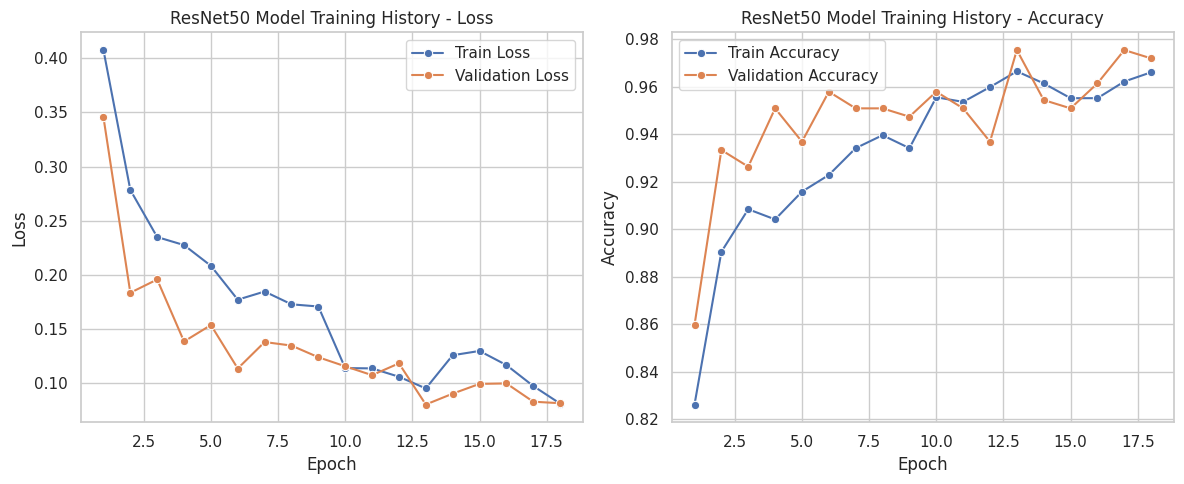

In [34]:
import warnings
import numpy as np

def plot_history(history, title='Model Training History'):
    """
    Plots the training and validation loss and accuracy from a history dictionary.

    Args:
        history (dict): A dictionary containing training history.
                        Expected keys: 'train_loss', 'val_loss',
                                       'train_acc', 'val_acc'.
        title (str): The title for the plot.
    """
    # Clean the input data (convert inf to NaN and handle NaN if necessary)
    for key in history:
        history[key] = [np.nan if np.isinf(x) else x for x in history[key]]

    epochs = range(1, len(history['train_loss']) + 1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)

        snsx.set_theme(style="whitegrid")
        pltx.figure(figsize=(12, 5))

        # Plot Loss
        pltx.subplot(1, 2, 1)
        snsx.lineplot(x=epochs, y=history['train_loss'], label='Train Loss', marker='o')
        snsx.lineplot(x=epochs, y=history['val_loss'], label='Validation Loss', marker='o')
        pltx.title(f'{title} - Loss')
        pltx.xlabel('Epoch')
        pltx.ylabel('Loss')
        pltx.legend()

        # Plot Accuracy
        pltx.subplot(1, 2, 2)
        snsx.lineplot(x=epochs, y=history['train_acc'], label='Train Accuracy', marker='o')
        snsx.lineplot(x=epochs, y=history['val_acc'], label='Validation Accuracy', marker='o')
        pltx.title(f'{title} - Accuracy')
        pltx.xlabel('Epoch')
        pltx.ylabel('Accuracy')
        pltx.legend()

        pltx.tight_layout()
        pltx.show()

# Usage
if config.check_training_status() and resnet_history:
    plot_history(resnet_history, title='ResNet50 Model Training History')
else:
    print("No training history to plot. Training may not have been performed.")



Evaluating on Test Set:

--- Evaluation Metrics ---
Average Loss: 0.0633
Accuracy: 0.9733
Precision: 1.0000
Recall: 0.9506
F1 Score: 0.9747
AUC: 0.9984
-------------------------

--- Classification Report ---
              precision    recall  f1-score   support

     Healthy       0.95      1.00      0.97        69
 Brain Tumor       1.00      0.95      0.97        81

    accuracy                           0.97       150
   macro avg       0.97      0.98      0.97       150
weighted avg       0.97      0.97      0.97       150

-------------------------


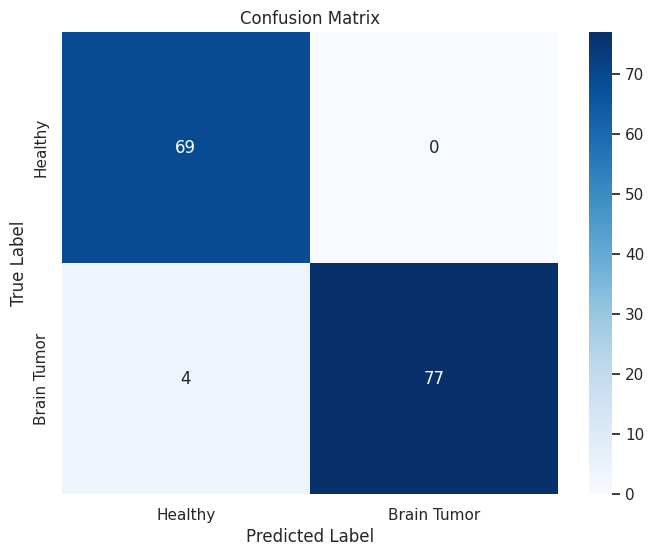

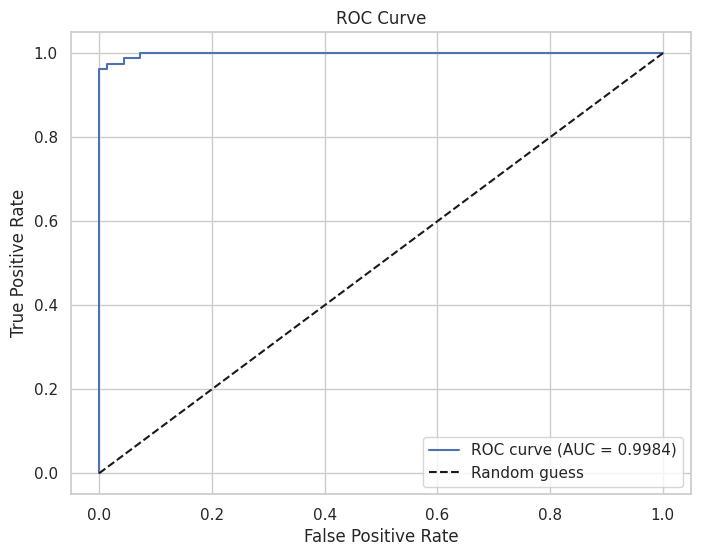

In [31]:
# Evaluate the model on the test set
print("\nEvaluating on Test Set:")
evaluate_and_plot(resnet_model, tst_ldr, criterion, dvc, class_names)


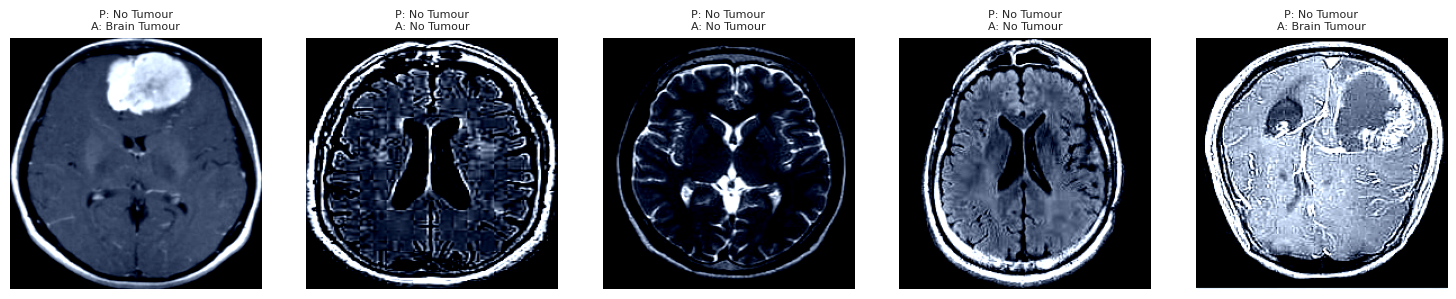

In [32]:
predict_random_from_loader(resnet_model, tst_ldr, dvc, num_images=5)